# Ускорение и оптимальные методы

# Подготовительная часть

как и ранее, рассмотрит задачу минимизации эмпирического риска:

\begin{equation}
\min_{x \in \mathbb{R}^d} \left[ f(x) = \frac{1}{n} \sum\limits_{i=1}^n \ell_x(a_i, b_i) + \frac{\lambda}{2} \| x \|^2_2\right],
\end{equation}

где:
- $\ell_x(a_i, b_i)$ — функция потерь (cross-entropy loss),
- $x$ — вектор параметров модели,
- $\{a_i, b_i\}_{i=1}^n$ — выборка данных,
- $\lambda > 0$ — параметр регуляризации.

Функция потерь для каждого объекта $i$ записывается как:

\begin{equation}
\ell_x(a_i, b_i) = -b_i \ln(p(x^Ta_i)) - (1 - b_i) \ln(1 - p(x^Ta_i)),
\end{equation}

где $p(x^Ta_i)$ — это вероятность, вычисляемая с помощью логистической функции в комбинации с линейной моделью:

\begin{equation}
p(x^Ta_i) = \frac{1}{1 + \exp(-x^T a_i)}.
\end{equation}




К заданию приложен датасет _mushrooms_. С помощью следующего кода сформируйте матрицу $A$ и вектор $b$, в которой и будет храниться выборка $\{a_i, b_i\}_{i=1}^n$. 

In [2]:
dataset = "mushrooms.txt" 
#файл должен лежать в той же деректории, что и notebook

In [3]:
from sklearn.datasets import load_svmlight_file
data = load_svmlight_file(dataset)
A, b = data[0].toarray(), data[1]

Поменяем вектор $y$, чтобы $y_i$ принимали значения $0$ и $1$. Вы также можете сделать дополнительную предобработку данных (приемами из машинного обучения), но это никак дополнительно не оценивается.

In [4]:
b = b - 1

Разделим данные на две части: обучающую и тестовую.

In [5]:
from sklearn.model_selection import train_test_split
GLOBAL_SEED = 11
A_train, A_test, b_train, b_test = train_test_split(A, b, test_size=0.2, random_state=GLOBAL_SEED)

Для обучающей части $A_{train}$, $b_{train}$ оцените константу $L$. Задайте $\lambda$ так, чтобы $\lambda \approx L / 1000$.  Реализуйте в коде подсчет значения градиента для нашей целевой функции ($A$, $b$, $\lambda$ лучше подавать в качестве параметра, чтобы была возможность их менять, а не только подставлять фиксированные $A_{train}$, $b_{train}$). Можно использовать как библиотеку ``numpy``, так и библиотеки ``autograd``, ``pytorch``, ``jax``. Воспользуйтесь кодом с предыдущего домашнего задания.

## Основная часть (всего 5 баллов) 

__Задача 1. (всего 2.5 балла)__ Метод Ньютона (классический и демпфированный)

Рассмотрим один из самых известных методов второго порядка - Метод Ньютона (Newton's method). А точнее его модификацию - демпфированный метод Ньютона (Dumped Newton's method, DNM). 

**Псевдокод алгоритма**

_Инициализация:_

Величина шага $\{ \gamma_k \}_{k=0} > 0$, стартовая точка $ x^0 \in \mathbb{R}^d $, количество итераций $ K $

$k \hspace{-1em}$ _--ая итерация:_
1. Подсчитать направление спуска $$ d_k = \left( \nabla^2 f(x^k) \right)^{-1} \nabla f(x_k)  $$
2. Сделать шаг алгоритма $$ x^{k+1} = x^k - \gamma_k d_k $$

Используйте предложенную функцию для реализации алгоритма и допишите недостающие фрагменты. После чего для проверки правильности загрузите функцию в [контест](https://contest.yandex.ru/contest/66540/enter/)

Как нетрудно заметить, при $\gamma_k \equiv 1$ демпфированный метод вырождается в классический (который, наверное, вам известен из вычислительной математики). 

### Указание: поставьте во всех методах точность по умолчанию равной $10^{-16}$.

__а) (0.25 балла)__ Для метода Ньютона нам нужно будет использовать значение гессиана функции потерь. Воспользуясь знаниями, полученными ранее, докажите, что градиент и гессиан равны, соответственно
$$
\nabla f(x) = \frac{1}{n} \sum_{i=1}^n (p(x^Ta_i) - b_i) a_i + \lambda x \qquad \qquad \nabla^2 f(x) = \frac{1}{n} \sum_{i=1}^n \big(p(x^Ta_i)(1 - p(x^Ta_i))\big) a_i a_i^T + \lambda I_d
$$

__Ваше решение__

Пояснения к выкладкам были в предыдущем задании. Здесь копия без пояснений

1)

$$\nabla p = \nabla \frac{1}{1 + \exp(-x^T a_i)} = \frac{a_i \exp(-x^T a_i)}{(1 + \exp(-x^T a_i))^2} = a_i p (1 - p)$$

2)

$$\nabla \ell_x(a_i, b_i) = \nabla (-b_i \ln(p) - (1 - b_i) \ln(1 - p)) = $$
$$ = -b_i \frac{\nabla p}{p} + (1 - b_i) \frac{\nabla p}{1 - p} = -b_i a_i (1 - p) + (1 - b_i) a_i p = $$
$$ = -a_i b_i + a_i p = (p - b_i) a_i$$

3)

$$\nabla f(x) = \frac{1}{n} \sum_{i=1}^n (p(x^Ta_i) - b_i) a_i + \lambda x$$

4)

$$\nabla^2 f(x) = \frac{1}{n} \sum_{i=1}^n \big(p(x^Ta_i)(1 - p(x^Ta_i))\big) a_i a_i^T + \lambda I_d$$

__б) (0.25 балла)__ Запустите демпфированный метод Ньютона для задачи логистической регрессии. Пусть $x_0 = 0$. Постройте график зависимости критерия от числа итераций (```max_iter``` поставьте не больше 10). Сходится ли метод?

In [25]:
import numpy as np
np.seterr(all='ignore')

n = A_train.shape[0]

eigvals = np.linalg.eigvals(A_train.T @ (A_train)) 
lambda_max = (np.max(eigvals) / (4 * n)).real
L = lambda_max # с точностью до 1/1000 
lmbd = L / 1000
mu = lmbd
print(f"L = {L}")
print(f"mu = {mu}")

def p_func(z):
    return 1.0 / (1.0 + np.exp(-z))

def f_func(x, A=A_train, b=b_train, lam=lmbd, eps=1e-16):
    n = A.shape[0]
    p = p_func(A @ x)
    return -np.mean(b * np.log(p + eps) + (1 - b) * np.log(1 - p + eps)) + lam * (x @ x) / 2

def grad_func(x, A=A_train, b=b_train, lam=lmbd, eps=1e-16):
    n = A.shape[0]
    p = p_func(A @ x)
    return (1 / n) * A.T.dot(p - b) + lam * x # .dot() работает быстрее, чем @

def hess_func(x, A=A_train, b=b_train, lam=lmbd, eps=1e-16):
    n = A.shape[0]
    m = A.shape[1]
    p = p_func(A @ x)
    return (1 / n) * A.T @ np.diag((1 - p) * p) @ A + lam * np.identity(m)

L = 2.5876922029794733
mu = 0.0025876922029794735


In [7]:
import numpy as np
from tqdm import trange

def DumpedNewton(grad, hess, criterion, A, b, x_0, eps, max_iter, **params):

    '''
       grad(x) - функция, которая считает градиент целевой функции;
       hess(x) - функция, которая считает гессиан целевой функции;
       criterion(x) - функция, которая считает критерий;
       x_0 - начальная точка;
       eps - точность сходимости (обычно 1e-8);
       max_iter - количество итераций;
       **params - содержит именнованные гиперпараметры метода:
           params['gamma'] - шаг;
           params['flag] -- флаг продолжения вычислений.
    '''

    errors = []

    x_k = np.copy(x_0)
    err_x_0 = criterion(x_k, A, b)

    if params['flag']:
        errors.append(criterion(x_k, A, b))
    else:
        errors.append(criterion(x_k, A, b) / err_x_0)

    for k in trange(max_iter):
            
        # Ваше решение
        gradient = grad(x_k, A, b)
        hessian = hess(x_k, A, b)
        d_k = np.linalg.inv(hessian) @ gradient
        x_k = x_k - params['gamma'](k) * d_k

        errors.append(criterion(x_k, A, b) / err_x_0)
        if errors[-1] < eps:
            break
            
    return x_k, errors

In [7]:
# Ваше решение (Code + Markdown)
x_0 = np.zeros(A.shape[1])
iterations = 10

def criterion(x, A, b, lam=lmbd):
    return np.linalg.norm(grad_func(x, A, b, lam)) / np.linalg.norm(grad_func(x_0, A, b, lam))

x_final, errors = DumpedNewton(grad_func, hess_func, criterion, A_train, b_train, x_0, eps=1e-16, max_iter=iterations, gamma=lambda k: 1,
                               flag=None)


 70%|████████████████████████████████▉              | 7/10 [00:01<00:00,  4.32it/s]


Text(0, 0.5, 'Логарифм критерия')

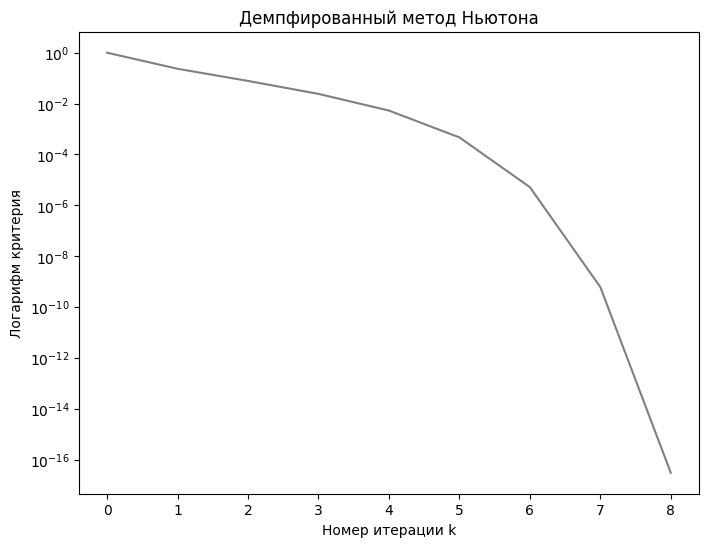

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(errors, color="grey")
ax.set_yscale('log')
ax.set_title(r"Демпфированный метод Ньютона")
ax.set_xlabel(r"Номер итерации k")
ax.set_ylabel(r"Логарифм критерия")

Метод сходится, но характер сходимости на таком малом числе итераций трудно определить

__в) (0.25 балла)__ Зафиксировав значение $\gamma_k=1$, рассмотрите следующие значения парметра $x_0$:
1. Вектор из 0;
2. Вектор из 1;
3. Вектора $\vec{e}_i$ ($i = 1, 2, \ldots , 8$), $j$-ая координата которых подчиняется следующему правилу:
$$  \left[ \vec{e}_i \right]_j = \begin{cases} i, & \text{если } j \leq i \\ 0, &\text{иначе} \end{cases}$$

Постройте графики зависимости критерия от числа итераций.

In [9]:
# Ваше решение (Code)
def construct_ei(m, i):
    return i * np.concatenate((np.ones(i), np.zeros(m - i)))

m = A.shape[1]
x_0s = [np.zeros(A.shape[1]),
        np.ones(A.shape[1]),
        construct_ei(m, 1),
        construct_ei(m, 2),
        construct_ei(m, 3),
        construct_ei(m, 4),
        construct_ei(m, 5),
        construct_ei(m, 6),
        construct_ei(m, 7),
        construct_ei(m, 8),]
iterations = 10

def criterion(x, A, b, lam=lmbd):
    return np.linalg.norm(grad_func(x, A, b, lam)) / np.linalg.norm(grad_func(x_0, A, b, lam))

x_answers_newton = []
errors_newton = []
for x_0 in x_0s:
    assert x_0.shape[0] == m
    x_final, errors = DumpedNewton(grad_func, hess_func, criterion, A_train, b_train, x_0, eps=1e-16, max_iter=iterations, gamma=lambda k: 1,
                                   flag=None)
    x_answers_newton.append(x_final)
    errors_newton.append(errors)



100%|██████████████████████████████████████████████| 10/10 [00:02<00:00,  4.78it/s]


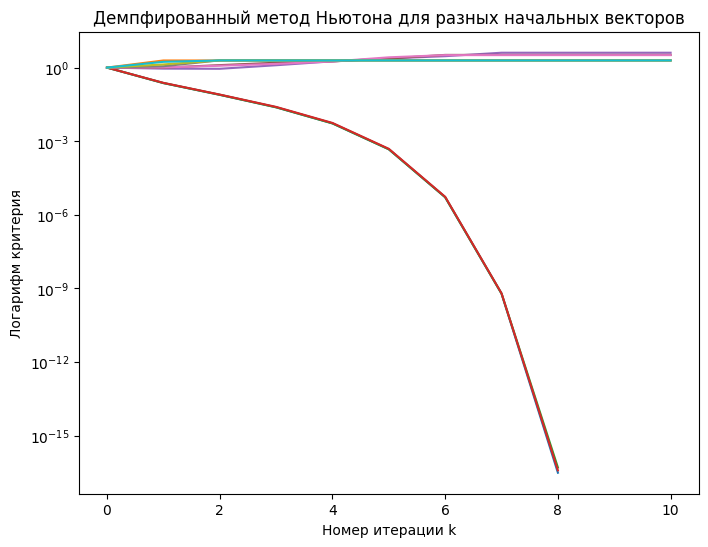

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for err in errors_newton:
    ax.plot(err)
    ax.set_yscale('log')
    ax.set_title(r"Демпфированный метод Ньютона для разных начальных векторов")
    ax.set_xlabel(r"Номер итерации k")
    ax.set_ylabel(r"Логарифм критерия")

Сходится только в тех случаях, когда число нулевых компонент не больше двух

__г) (0.5 балла)__ Выберите и зафиксируйте произвольное значение $x_0$ из предыдущего пункта, для которого наблюдается сходимость DNM. Теперь исследуем зависимость сходимости от параметра $\gamma_k$. Для этого проверьте следующие значения $\gamma_k = \{ 0.5, 1, 1.5, 2 \}$. Постройте графики зависимости критерия от числа итераций.

In [11]:
# Ваше решение (Code)
x_0 = construct_ei(m, 1)
iterations = 10

gammas = [0.5, 1.0, 1.5, 2.0]

def criterion(x, A, b, lam=lmbd):
    return np.linalg.norm(grad_func(x, A, b, lam)) / np.linalg.norm(grad_func(x_0, A, b, lam))

x_answers_newton = []
errors_newton = []
for gamma in gammas:
    x_final, errors = DumpedNewton(grad_func, hess_func, criterion, A_train, b_train, x_0, eps=1e-16, max_iter=iterations, gamma=lambda k: gamma,
                                   flag=None)
    x_answers_newton.append(x_final)
    errors_newton.append(errors)

100%|██████████████████████████████████████████████| 10/10 [00:01<00:00,  5.17it/s]


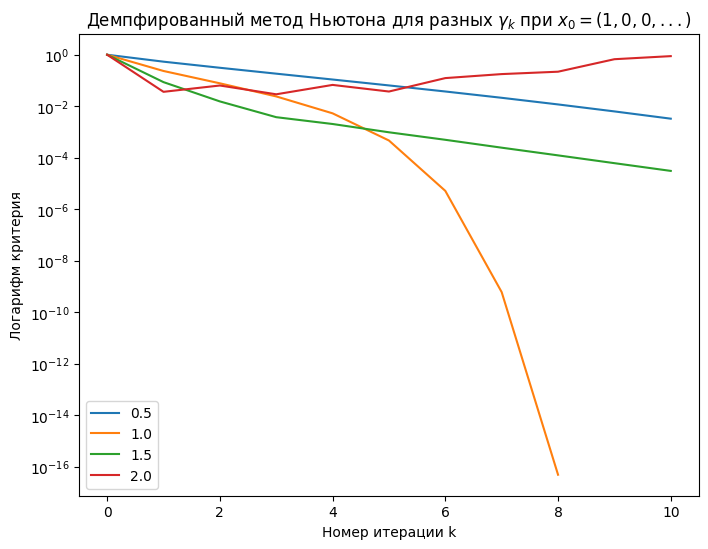

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for err, gamma in zip(errors_newton, gammas):
    ax.plot(err, label=str(gamma))
    ax.set_yscale('log')
    ax.set_title(r"Демпфированный метод Ньютона для разных $\gamma_k$ при $x_0 = (1,0,0,...)$")
    ax.set_xlabel(r"Номер итерации k")
    ax.set_ylabel(r"Логарифм критерия")
ax.legend()

__д) (0.75 балла)__ Давайте теперь вызовем несколько итераций метода градиентного спуска, перед использованием демпфированного метода Ньютона (воспользуйтесь результатами предыдущих домашек). Варьируя число итераций градиентного спуска (возьмите 10, 20, 50, 100), исследуйте сходимость метода DNM при фиксированных значениях $x_0$ (возьмите вектор из единиц) и $\gamma_k = 1$. 

In [8]:
# Ваше решение (Code)
from tqdm.autonotebook import tqdm
def GradientDescent(grad, criterion, A, b, x_0, eps, max_iter, **params):

    '''
       grad(x) - функция, которая считает градиент целевой функции;
       criterion(x) - функция, которая считает критерий;
       x_0 - начальная точка;
       eps - точность сходимости (обычно 1e-8);
       max_iter - количество итераций;
       **params - содержит именнованные гиперпараметры метода:
           params['gamma'](k) - шаг, зависящий от номера итерации.
    '''

    errors = []

    x_k = np.copy(x_0)
    err_x_0 = criterion(x_k, A, b)
    errors.append(criterion(x_k, A, b) / err_x_0)
    for k in tqdm(range(max_iter)):

        # your code
        x_k = x_k - params['gamma'](k) * grad(x_k, A, b)

        errors.append(criterion(x_k, A, b) / err_x_0)
        if errors[-1] < eps:
            break

    return x_k, errors

x_0 = np.ones(A.shape[1])
iterations_array = [10, 20, 50, 100]

errors_with_grad = []
for iterations in iterations_array:
    x_grad, errors_grad = GradientDescent(grad_func, criterion, A_train, b_train, x_0, eps=1e-8, max_iter=iterations, gamma=lambda k: 1/L)
    x_newt, errors_newt = DumpedNewton(grad_func, hess_func, criterion, A_train, b_train, x_grad, eps=1e-16, max_iter=10, gamma=lambda k: 1,
                                       flag=None) # всё равно не поставил флаг продолжения вычислений
    errors_with_grad.append(errors_newt)

C:\Users\NIKITA\AppData\Local\Temp\ipykernel_160508\2759285200.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


NameError: name 'criterion' is not defined

4


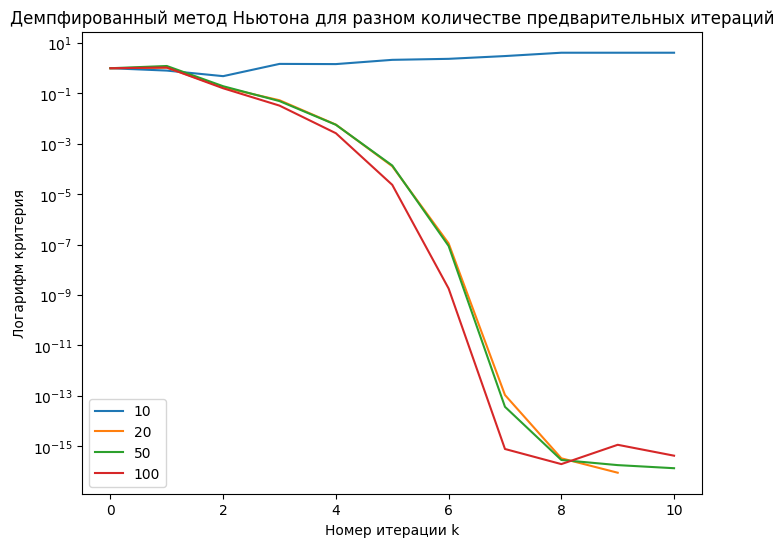

In [14]:
print(len(errors_with_grad))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for err, it in zip(errors_with_grad, iterations_array):
    ax.plot(err, label=str(it))
    ax.set_yscale('log')
    ax.set_title(r"Демпфированный метод Ньютона для разном количестве предварительных итераций")
    ax.set_xlabel(r"Номер итерации k")
    ax.set_ylabel(r"Логарифм критерия")
ax.legend()

__е) (0.25 балла)__ Теперь рассмотрим датасет ```w8a.txt```. Его размеры несколько больше, чем у ```mushrooms.txt``` (сравните, насколько), поэтому вычисление гессиана будет занимать больше времени. Повторите предыдущий пункт, используя те же значения для количества предварительных шагов градиентного спуска, а число итераций демпфированного метода Ньютона положите равной 5.

In [9]:
dataset = "w8a.txt" 

print(f"Размер тренировочной для mushrooms.txt - {A_train.shape}")

from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

data = load_svmlight_file(dataset, )
A, b = data[0].toarray(), data[1]

A_train, A_test, b_train, b_test = train_test_split(A, b, test_size=0.2, random_state=GLOBAL_SEED)

print(f"Размер тренировочной для w8a.txt - {A_train.shape}")


Размер тренировочной для mushrooms.txt - (6499, 112)
Размер тренировочной для w8a.txt - (39799, 300)


In [17]:
# Ваше решение (Code)
x_0 = np.ones(A.shape[1])
iterations_array = [10, 20, 50, 100]

errors_with_grad = []
for iterations in iterations_array:
    x_grad, errors_grad = GradientDescent(grad_func, criterion, A_train, b_train, x_0, eps=1e-8, max_iter=iterations, gamma=lambda k: 1/L)
    x_newt, errors_newt = DumpedNewton(grad_func, hess_func, criterion, A_train, b_train, x_grad, eps=1e-16, max_iter=5, gamma=lambda k: 1,
                                       flag=None) # всё равно не поставил флаг продолжения вычислений
    errors_with_grad.append(errors_newt)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████| 5/5 [00:55<00:00, 11.19s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

 80%|██████████████████████████████████████▍         | 4/5 [00:55<00:13, 13.85s/it]


  0%|          | 0/50 [00:00<?, ?it/s]

 80%|██████████████████████████████████████▍         | 4/5 [00:51<00:12, 12.98s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

 80%|██████████████████████████████████████▍         | 4/5 [00:53<00:13, 13.35s/it]


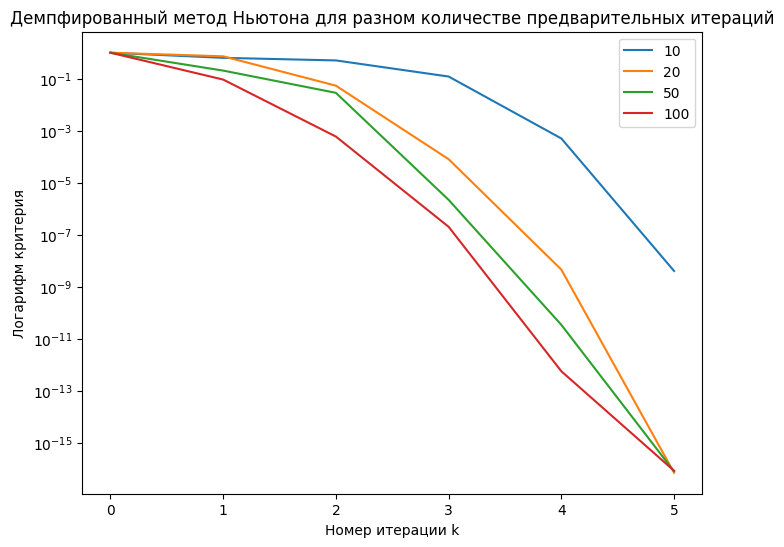

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for err, it in zip(errors_with_grad, iterations_array):
    ax.plot(err, label=str(it))
    ax.set_yscale('log')
    ax.set_title(r"Демпфированный метод Ньютона для разном количестве предварительных итераций")
    ax.set_xlabel(r"Номер итерации k")
    ax.set_ylabel(r"Логарифм критерия")
ax.legend()

__ё) (0.25 балла)__ В данном пункте нужно будет сравнить временную сложность алгоритмов первого порядка (```GradientDescent, HeavyBall, NAG```) и предложенных в данной домашней работе реализаций метода Ньютона (```DumpedNewton``` и связку ```GradientDescent + DumpedNewton```). Для всех методов выберите $x_0 = 0$, $\varepsilon = 10^{-16}$ и следующие значения параметров:
1. ```GradientDescent```: max_iter = 3000, $\gamma_k = 1/L$;
2. ```HeavyBall```: max_iter = 3000, $\gamma_k = 1/L$, $\tau_k = 0.9$;
3. ```NAG```: max_iter = 3000, $\gamma_k = 1/L$, $\tau_k = 0.9$;
4. ```DumpedNewton```: max_iter = 8, $\gamma_k = 1$;
5. ```GradientDescent + DumpedNewton```: число шагов градиентного спуска - 100, число шагов метода Ньютона - 5, параметры методов такие же, как в пунктах 1 и 4.

Сделайте вывод о применимости метода Ньютона.


In [10]:
# Ваше решение (Code + Markdown)
import numpy as np
from tqdm import trange

def HeavyBall(grad, criterion, A, b, x_0, eps, max_iter, **params):

    '''
       grad(x) - функция, которая считает градиент целевой функции;
       criterion(x) - функция, которая считает критерий;
       x_0 - начальная точка;
       eps - точность сходимости (обычно 1e-8);
       max_iter - количество итераций;
       **params - содержит именнованные гиперпараметры метода:
           params['gamma'](k) - шаг, зависящий от номера итерации,
           params['tau'](k) - моментум, зависящий от номера итерации.
    '''

    errors = []

    x_k = np.copy(x_0)
    x_k_prev = np.copy(x_0)
    err_x_0 = criterion(x_k, A, b)
    errors.append(criterion(x_k, A, b) / err_x_0)
    for k in trange(max_iter):

        # Ваше решение
        gradient = grad(x_k, A, b)
        x_k_new = x_k - params['gamma'](k) * gradient + params['tau'](k) * (x_k - x_k_prev)
        x_k_prev = np.copy(x_k)
        x_k = np.copy(x_k_new)

        errors.append(criterion(x_k, A, b) / err_x_0)
        if errors[-1] < eps:
            break

    return x_k, errors

def NAG(grad, criterion, A, b, x_0, eps, max_iter, **params):
    '''
       grad(x) - функция, которая считает градиент целевой функции;
       criterion(x) - функция, которая считает критерий;
       x_0 - начальная точка;
       eps - точность сходимости (обычно 1e-8);
       max_iter - количество итераций;
       **params - содержит именнованные гиперпараметры метода:
           params['gamma'](k) - шаг, зависящий от номера итерации,
           params['tau'](k) - моментум, зависящий от номера итерации.
    '''
    errors = []

    x_k = np.copy(x_0)
    y_k = np.copy(x_0)
    err_x_0 = criterion(x_k, A, b)
    errors.append(criterion(x_k, A, b) / err_x_0)
    delta = np.zeros_like(x_0)

    for k in trange(max_iter):

        # Ваше решение
        gradient = grad(y_k, A, b)
        x_k_new = y_k - params['gamma'](k) * gradient
        y_k_new = x_k_new + params['tau'](k) * (x_k_new - x_k)
        x_k = np.copy(x_k_new)
        y_k = np.copy(y_k_new)

        errors.append(criterion(x_k, A, b) / err_x_0)
        if errors[-1] < eps:
            break
    return x_k, errors

In [23]:
m = A.shape[1]
x_0 = np.zeros(m)

n = A_train.shape[0]
eigvals = np.linalg.eigvals(A_train.T @ (A_train)) 
lambda_max = (np.max(eigvals) / (4 * n)).real
L = lambda_max # с точностью до 1/1000 
lmbd = L / 1000
mu = lmbd
print(f"L = {L}")
print(f"mu = {mu}")

from time import time

start = time()
x_gd, errors_gd = GradientDescent(grad_func, criterion, A_train, b_train, x_0, eps=1e-16, max_iter=3000, gamma=lambda k: 1/L)
time_gd = time() - start
start = time()
x_hb, errors_hb = HeavyBall(grad_func, criterion, A_train, b_train, x_0, eps=1e-16, max_iter=3000, gamma=lambda k: 1/L, tau=lambda k: 0.9)
time_hb = time() - start
start = time()
x_nag, errors_nag = NAG(grad_func, criterion, A_train, b_train, x_0, eps=1e-16, max_iter=3000, gamma=lambda k: 1/L, tau=lambda k: 0.9)
time_nag = time() - start
start = time()
x_dnm, errors_dnm = DumpedNewton(grad_func, hess_func, criterion, A_train, b_train, x_0, eps=1e-16, max_iter=8, gamma=lambda k: 1, flag=None)
time_dnm = time() - start
start = time()
gd, _ = GradientDescent(grad_func, criterion, A_train, b_train, x_0, eps=1e-16, max_iter=100, gamma=lambda k: 1/L)
x_comb, errors_comb = DumpedNewton(grad_func, hess_func, criterion, A_train, b_train, gd, eps=1e-16, max_iter=5, gamma=lambda k: 1, flag=None)
time_comb = time() - start

L = 0.6639330196602973
mu = 0.0006639330196602973


  0%|          | 0/3000 [00:00<?, ?it/s]

 75%|████████████████████████████████████            | 6/8 [01:18<00:26, 13.12s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.24s/it]


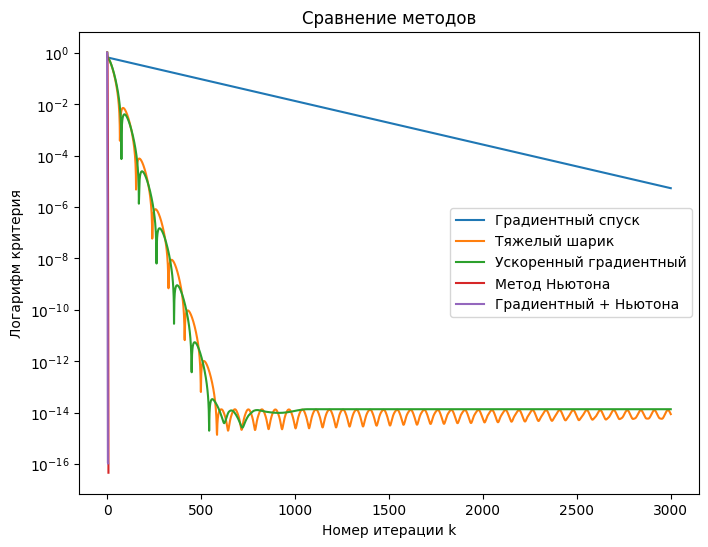

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(errors_gd, label="Градиентный спуск")
ax.plot(errors_hb, label="Тяжелый шарик")
ax.plot(errors_nag, label="Ускоренный градиентный")
ax.plot(errors_dnm, label="Метод Ньютона")
ax.plot(errors_comb, label="Градиентный + Ньютона")
ax.set_yscale('log')
ax.set_title(r"Сравнение методов")
ax.set_xlabel(r"Номер итерации k")
ax.set_ylabel(r"Логарифм критерия")
ax.legend()

Text(0, 0.5, 'Время в секундах')

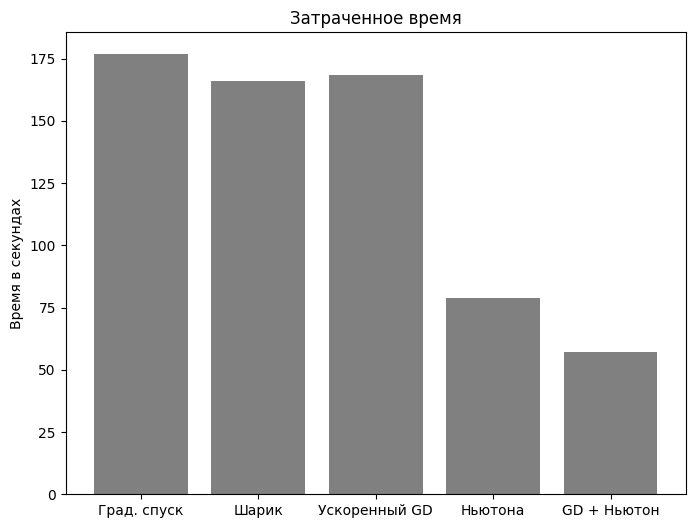

In [29]:
times = [time_gd, time_hb, time_nag, time_dnm, time_comb]
names = ["Град. спуск", "Шарик", "Ускоренный GD", "Ньютона", "GD + Ньютон"]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.bar(names, times, color="gray")
ax.set_title(r"Затраченное время")
ax.set_ylabel(r"Время в секундах")

Метод Ньютона сходится быстрее других и использует гораздо меньше итераций. Однако он требует знания оракула второго порядка, и каждая итерация считается в разы медленнее других методов. Тем не менее, те методы даже не сошлись за заданное количество итераций, что подтверждает превосходство метода Ньютона на выборках размера порядка десятков тысяч.

__Задача 2. (всего 2.5 балла)__ Квазиньютоновские методы

Вычисление обратной матрицы Гесса является крайне ресурсоемким, поэтому предлагается использовать вместо ее точного значения некоторую аппроксимацию невырожденной положительно определенной матрицей. Такие методы называются *квазиньютоновскими*. В данной части будет предложен к рассмотрению один из самых популярных методов оптимизации.

__а) (0.5 балла)__ Реализуйте квазиньютоновский метод L-BFGS (см. [статью](https://users.iems.northwestern.edu/~nocedal/PDFfiles/limited-memory.pdf)), основанный на аппроксимации $H_k$. 

**Псевдокод алгоритма**

_Инициализация:_

Параметры линейного поиска $c_1, c_2$, аппроксимация обратного гессиана $H_0$, стартовая точка $ x^0 \in \mathbb{R}^d $, количество итераций $ K $

$k \hspace{-1em}$ _--ая итерация:_

1. Подсчитать направление спуска, используя аппроксимацию обратного гессиана $H_k$:
$$d_k = -H_k \nabla f(x_k).$$
2. Выполнить процедуру линейного поиска параметра $\alpha_k$, удовлетворяющего условиям Вольфе (см. [определение](https://en.wikipedia.org/wiki/Wolfe_conditions)):
$$\begin{align*}
f(x_k + \alpha_k d_k) &\leq f(x_k) + c_1 \alpha_k d_k^T \nabla f(x_k)\\
-d_k^T \nabla f(x_k + \alpha_k d_k)  &\leq -c_2 d_k^T \nabla f(x_k)
\end{align*}$$ 
3. Обновить $x_k$:
$$x_{k + 1} = x_k + \alpha_k d_k$$
4. Ввести $$\begin{align*} s_k &= x_{k + 1} - x_k \\ y_k &= \nabla f(x_{k + 1}) - \nabla f(x_k)\end{align*}$$ и обновить значение $H_k$:
$$
H_{k +1} = \left( I - \frac{y_k s_k^T}{y_k^T s_k} \right)^T H_k \left( I - \frac{y_k s_k^T}{y_k^T s_k} \right) + \frac{y_k s_k^T}{s_k^T s_k}
$$


*Замечание*: подумайте, как лучше инициализировать матрицу $H_0$. Функцию линейного поиска можно реализовать самостоятельно, а можете воспользоваться реализацией из библиотеки ```scipy.optimize```. 

Используйте предложенную функцию для реализации алгоритма и допишите недостающие фрагменты. После чего для проверки правильности загрузите функцию в [контест](https://contest.yandex.ru/contest/66540/enter/)

In [85]:
from tqdm import trange
from scipy.optimize import line_search

def BFGS(f, grad, H_0, criterion, A, b, x_0, eps, max_iter, **params):
    '''
        f(x) - оптимизируемая функция
        grad(x) - функция, которая считает градиент целевой функции;
        H_0 - аппроксимация гессиана невырожденной положительно определенной матрицей;
        criterion(x) - функция, которая считает критерий;
        x_0 - начальная точка;
        eps - точность сходимости (обычно 1e-8);
        max_iter - количество итераций;
        **params - содержит именнованные гиперпараметры метода:
            params['c_1'] - параметр в условие Вольфе, по умолчанию равен 0.0001
            params['c_2'] - параметр в условие Вольфе, по умолчанию равен 0.9
    '''
    errors = []

    err_x_0 = criterion(x_0, A, b)
    errors.append(criterion(x_0, A, b) / err_x_0)

    H_k = np.copy(H_0)

    x_k = np.array(x_0)
    x_new = np.array(x_0)

    g_k = grad(x_0, A, b)
    g_new = grad(x_0, A, b)

    I = np.eye(d)
    alpha_k = None

    for k in trange(max_iter):

        # Ваше решение
        g_k = grad(x_k, A, b)
        d_k = -H_k @ g_k
        while alpha_k is None:
            alpha_k = line_search(f, grad, x_k, -g_k, c1=params["c_1"], c2=params["c_2"])[0]
        x_new = x_k + alpha_k * d_k
        g_new = grad(x_new, A, b)
        s_k = x_new - x_k
        y_k = g_new - g_k
        H_k = (I - (np.outer(y_k, s_k)) / (np.dot(y_k, s_k))).T @ H_k @ (I - (np.outer(y_k, s_k)) / (np.dot(y_k, s_k))) + (np.outer(s_k, s_k)) / (np.dot(y_k, s_k))
        x_k = x_new
        g_k = g_new
        
        errors.append(criterion(x_new, A, b) / err_x_0)
        if errors[-1] < eps:
            break

    return x_new, errors

Вернемся к датасету ```mushrooms.txt```, для ускорения работы алгоритмов.

In [12]:
dataset = "mushrooms.txt" 

from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

data = load_svmlight_file(dataset)
A, b = data[0].toarray(), data[1]

b = 2 * b - 3

A_train, A_test, b_train, b_test = train_test_split(A, b, test_size=0.2, random_state=GLOBAL_SEED)

__б) (0.5 балла)__ Рассмотрите различные значения параметра $x_0$, как в пункте __1б)__. Число итераций поставьте равным 150. Постройте график зависимости критерия от номера итерации. Проведите сравнение с подобными графиками для DNM.

In [91]:
# Ваше решение (Code)

d = A.shape[1]
x_0 = np.zeros(d)
H_0 = hess_func(x_0, A_train, b_train)
iterations = 150

def criterion(x, A=A_train, b=b_train, lam=lmbd):
    return np.linalg.norm(grad_func(x, A, b, lam)) / np.linalg.norm(grad_func(x_0, A, b, lam))

x_final, errors = BFGS(f_func, grad_func, H_0, criterion, A_train, b_train, x_0, eps=1e-16, max_iter=iterations, c_1=0.001, c_2=0.9)

100%|███████████████████████████████████████████| 150/150 [00:00<00:00, 444.18it/s]


In [94]:
def construct_ei(m, i):
    return i * np.concatenate((np.ones(i), np.zeros(m - i)))

d = A.shape[1]
x_0s = [np.zeros(d),
        np.ones(d),
        construct_ei(d, 1),
        construct_ei(d, 2),
        construct_ei(d, 3),
        construct_ei(d, 4),
        construct_ei(d, 5),
        construct_ei(d, 6),
        construct_ei(d, 7),
        construct_ei(d, 8),]
H_0s = [hess_func(x_0, A_train, b_train) for x_0 in x_0s]
iterations = 150

def criterion(x, A=A_train, b=b_train, lam=lmbd):
    return np.linalg.norm(grad_func(x, A, b, lam)) / np.linalg.norm(grad_func(x_0, A, b, lam))

x_answers_bfgs = []
errors_bfgs = []
for x_0, H_0 in zip(x_0s, H_0s):
    assert x_0.shape[0] == d
    x_final, errors = BFGS(f_func, grad_func, H_0, criterion, A_train, b_train, x_0, eps=1e-16, max_iter=iterations, c_1=0.0001, c_2=0.9)
    x_answers_bfgs.append(x_final)
    errors_bfgs.append(errors)

100%|███████████████████████████████████████████| 150/150 [00:00<00:00, 455.73it/s]


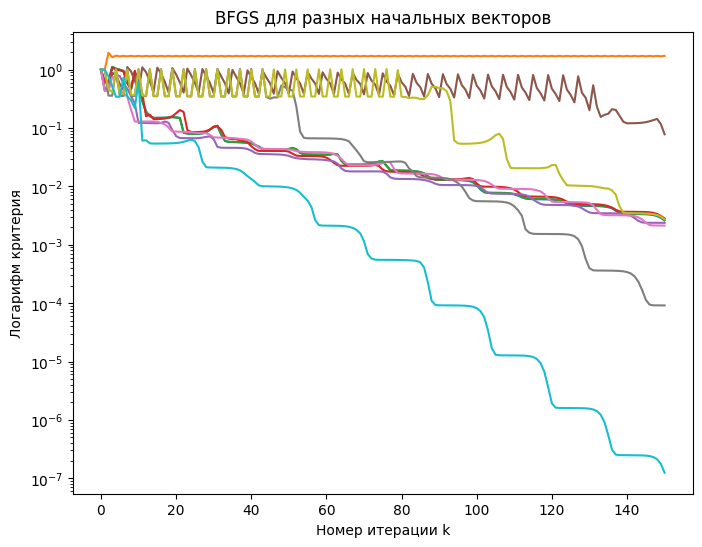

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for err in errors_bfgs:
    ax.plot(err)
    ax.set_yscale('log')
    ax.set_title(r"BFGS для разных начальных векторов")
    ax.set_xlabel(r"Номер итерации k")
    ax.set_ylabel(r"Логарифм критерия")

__в) (0.75 балла)__ Однако, такое приближение гессианов не единственно. Реализуйте метод SR1 (Symmetric rank-1) (см. [статью](https://arxiv.org/pdf/2002.00657.pdf)) со следующим обновлением аппроксимации обратного гессиана:
$$
H_{k + 1} = H_k + \frac{(s_k - H_k y_k)(s_k - H_k y_k)^T}{(s_k - H_k y_k)y_k^T}.
$$

In [ ]:
from tqdm import trange
from scipy.optimize import line_search

def SR1(f, grad, H_0, x_0, criterion, eps, max_iter, **params):
    '''
        f(x) - оптимизируемая функция
        grad(x) - функция, которая считает градиент целевой функции;
        H_0 - аппроксимация гессиана невырожденной положительно определенной матрицей;
        criterion(x) - функция, которая считает критерий;
        x_0 - начальная точка;
        eps - точность сходимости (обычно 1e-8);
        max_iter - количество итераций;
        **params - содержит именнованные гиперпараметры метода:
            params['c_1'] - параметр в условие Вольфе, по умолчанию равен 0.0001
            params['c_2'] - параметр в условие Вольфе, по умолчанию равен 0.9
    '''
    errors = []

    err_x_0 = criterion(x_0)
    errors.append(criterion(x_0) / err_x_0)

    H_k = np.copy(H_0)

    x_k = np.array(x_0)
    x_new = np.array(x_0)

    g_k = grad(x_0)
    g_new = grad(x_0)

    for k in trange(max_iter):

        # Ваше решение

        errors.append(criterion(x_new) / err_x_0)
        if errors[-1] < eps:
            break

    return x_new, errors

__г) (0.75 балла)__ Теперь давайте сравним работу квазиньютоновских методов с ускоренным методом (возьмите NAG) и методом второго порядка (DumpedNewton). В качестве начальной точки выберите $x_0 = 0$. Постройте сравнительные графики зависимостей критерия от итерации и критерия от времени. Что можно сказать о применимости квазиньютоновских методов? 

In [ ]:
# Ваше решение (Code + Markdown)

## Дополнительная часть (всего 5 баллов)

__Задача 3. (всего 5 баллов)__ Квазиньютоновские методы очень хороши, так как не требуют использование второго порядка гладкости. Однако, все равно приходится хранить приближения матрицы Гесса, что при больших размерностях задачи очень сильно влияет на асимптотику по памяти, делая ее квадратичной. Для оптимизации этой величины были представлены методы с представкой L- (L-BFGS, L-SR1), где L- означает limited memory.

__a) (1 балл)__ Реализуйте метод L-BFGS, использующий технику ограниченной памяти с асимптотикой $\mathcal{O}(n)$. Пусть разрешено использовать $m$ значений с предыдущих итераций. Тогда псевдокод на $k$-ой итерации:

**Псевдокод алгоритма**

_Инициализация:_

Параметры линейного поиска $c_1, c_2$, стартовая аппроксимация обратного гессиана $H_0^k$, стартовая точка $ x^0 \in \mathbb{R}^d $, количество итераций $ K $

$k \hspace{-1em}$ _--ая итерация:_

1. Создать переменную $q = g_k$.
2. Для $i = k - 1, \ldots, k - m$ уточнить аппроксимацию градиента $q$, сохранив при этом вычисленное значение $\alpha_i$:
$$
\alpha_i =\rho_i s_i^T q \qquad \qquad q = q - \alpha_i y_i.
$$
3. Задать нулевое приблежение обратного гессиана $H_k^0$ (как в статье, вы же можете рассмотреть другое):
$$
H_k^0 = \frac{s_{k-1}^T y_{k-1}}{y_{k-1}^T y_{k-1}} I.
$$
4. Вычислить значение спуска:
$$
r = H_k^0 q
$$
5. Для $i = k - m, \ldots, k - 1$ уточнить значение вектора спуска $r$:
$$
r = r + s_i (\alpha_i - \rho_i y_i^T r).
$$
6. Сделать стандартные обновления для подсчета $x_{k + 1}, s_k, y_k, \rho_k$, сохранить их в память. Если память переполнена -- убрать элемент с индексом 0 (то есть тот, который был положен раньше остальных).

Используйте предложенную функцию для реализации алгоритма и допишите недостающие фрагменты. После чего для проверки правильности загрузите функцию в [контест](https://contest.yandex.ru/contest/66540/enter/)

In [ ]:
import copy
def LBFGS(f, grad, H_0, x_0, mem_size, criterion, eps, max_iter, **params):
    '''
        f(x) - оптимизируемая функция
        grad(x) - функция, которая считает градиент целевой функции;
        H_0 - аппроксимация гессиана невырожденной положительно определенной матрицей;
        mem_size - количество выделенной памяти, по умолчанию 1;
        criterion(x) - функция, которая считает критерий;
        x_0 - начальная точка;
        eps - точность сходимости (обычно 1e-8);
        max_iter - количество итераций;
        **params - содержит именнованные гиперпараметры метода:
            params['c_1'] - параметр в условие Вольфе, по умолчанию равен 0.0001
            params['c_2'] - параметр в условие Вольфе, по умолчанию равен 0.9
    '''
    errors = []
    time_logs = []

    err_x_0 = criterion(x_0)
    errors.append(criterion(x_0) / err_x_0)

    H_k = np.copy(H_0)

    x_k = np.array(x_0)
    x_new = np.array(x_0)

    g_k = grad(x_0)
    g_new = grad(x_0)

    I = np.eye(d)

    time_logs.append(0)

    x_diffs = []
    grad_diffs = []
    rhos = []

    for k in trange(max_iter):

        # Ваше решение

        if errors[-1] < eps:
            break

    return x_new, errors, time_logs

__б) (0.5 балла)__ Сравните сходимость метода при разных значениях параметра ```mem_size```. Рассмотрите следующие значения: 1, 10, 100, 1000, 10000. Постройте графики зависимости критерия от номера итерации и критерия от времени. Сравните также с BFGS. Что можно сказать об алгоритме с ограниченной памятью?

In [ ]:
# Ваше решение (Code)

__в)__ __(2 балла)__ До этого мы рассматривали методы, требующие липшицевость градиента. Однако, существует алгоритм, требующий липшицевость гессиана. Это метод Ньютона с кубической регуляризацией, предложенный Ю.$~$Нестеровым и Б.$~$Т.$~$Поляком в [этой работе](https://link.springer.com/article/10.1007/s10107-006-0706-8). На его $k$-ой итерации необходимо отрешивать следующую подзадачу:
$$
x_{k + 1} = \arg \min \limits_{x \in \mathbb{R}^d} \left\{ \langle \nabla f(x_k), x - x_k \rangle + \frac{1}{2} \langle \nabla^2 f(x_k) (x - x_k), x - x_k \rangle + \frac{M_k}{6} \| x - x_k\|_2^2 \right\}
$$
Здесь $M_k$ -- константа Липшица гессиана. Так как в общем случае вычислять тензор третьего ранга не очень выгодно, предлагается рассмотреть адаптивную константу, которую мы будем задавать как
$$
M_k = \frac{\alpha}{\left( 1 + \beta^{1 + k} \right)},
$$
константы $\alpha$ и $\beta$ для начала можно положить равными 0.005 и 0.15, соответственно.

In [ ]:
def solve_cubic(x_k, f, g_k, H_k, M, criterion, eps=1e-8, max_iter=10):
    '''
        x_k - точка, в которой решается задача минимизации;
        f(x) - целевая функция:
        g_k - значение градиента функции в точке x_k;
        H_k - значение гессиана функции в точке x_k;
        M - константа Липшица гессиана;
        criterion(x, y) - функция, считающая критерий останова, в оригинальной статье взят 1/||x|| - 1/||y||;
        eps - точность сходимости (обычно 1e-8);
        max_iter - количество итераций для решения подзадачи, по умолчанию 10;
    '''
    # Inner variable to trace amount of steps made inside the subproblem
    solver_it = 1

    newton_step = -np.linalg.solve(H_k, g_k)
    if M == 0:
        return x_k + newton_step, solver_it

    def cauchy_point(g, H, M):
        if np.linalg.norm(g) == 0 or M == 0:
            return 0 * g

        g_dir = g / np.linalg.norm(g)
        H_g_g = H @ g_dir @ g_dir
        R = -H_g_g / (2*M) + np.sqrt((H_g_g/M)**2 / 4 + np.linalg.norm(g)/M)
        return -R * g_dir

    r_min = np.linalg.norm(cauchy_point(g_k, H_k, M))

    x_new = x_k + newton_step
    if f(x_k) > f(x_new):
        return x_new, solver_it

    r_max = np.linalg.norm(newton_step)
    if r_max - r_min < eps:
        return x_k + newton_step, solver_it

    I = np.eye(len(g_k))

    for _ in range(max_iter):
        r_try = (r_min + r_max) / 2
        lam = r_try * M
        s_lam = -np.linalg.solve(H_k + lam * I, g_k)
        solver_it += 1

        crit = 1./np.linalg.norm(s_lam) - 1./np.linalg.norm(r_try)
        if np.abs(crit) < eps:
            return x_k + s_lam, solver_it

        if crit < 0:
            r_min = r_try
        else:
            r_max = r_try
        if r_max - r_min < eps:
            break
    return x_k + s_lam, solver_it

In [ ]:
from tqdm import tqdm

def CubicNewton(f, grad, H, x_0, criterion, eps, max_iter, **params):
    '''
        f(x) - оптимизируемая функция
        grad(x) - функция, которая считает градиент целевой функции;
        H(x) - функция, которая считает гессиан целевой функции;
        criterion(x) - функция, которая считает критерий;
        x_0 - начальная точка;
        eps - точность сходимости (обычно 1e-8);
        max_iter - количество итераций;
        **params - содержит именнованные гиперпараметры метода:
            params['M'] - константа Липшица гессиана, она же константа кубического регуляризатора
    '''

    errors = []

    err_x_0 = criterion(x_0)
    errors.append(criterion(x_0) / err_x_0)

    x_k = np.array(x_0)
    g_k = grad(x_0)
    H_k = H(x_0)

    for k in tqdm(range(max_iter)):

        M_k = params['M'](k)

        x_k, solver_it = solve_cubic(x_k, f, g_k, H_k, M_k, criterion, eps=1e-16, max_iter=2)
        k += solver_it
        g_k = grad(x_k)
        H_k = H(x_k)

        errors.append(criterion(x_k) / err_x_0)
        if errors[-1] < eps:
            break

    return x_k, errors

__г) (0.25 балла)__ Примените кубически регуляризованный метод Ньютона для ERM. Постройте график зависимости значения критерия от итерации.

In [ ]:
# Решение (Code)

__д) (0.25 балла)__ Давайте подберем теперь наилучшие значения параметров $\alpha, \beta$, обеспечивающих наискорейшую сходимость метода. Для этого рассмотрите $\alpha = \{ 10^{-1}, 10^{-2}, 10^{-3}, 10^{-4} \}$ и $\beta = \{ 1, 0.5, 0.1, 0.05 \}$.

In [ ]:
# Ваше решение (Code)

__е) (1 балл)__ И финальное сравнение - постройте сравнительные графики для всех изученных методов в данной домашней работе. Параметры подберите так, чтобы они обеспечивали наилучшую сходимость методов. 

In [ ]:
# Ваше решение (Code + Markdown)